In [20]:
import requests
import math
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import pandas as pd
from sklearn import linear_model
from scipy import stats as st
from PIL import Image
from scipy.stats import norm
import scipy.stats as stat
from scipy.stats import beta
from scipy.stats import triang
from scipy.stats import lognorm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn.linear_model as lm
from matplotlib import cm

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

In [21]:
import json
import glob
import os
from pathlib import Path

from epilepsypcm.utils.make_df import make_df, get_df_list, concat_dfs
from epilepsypcm.utils.outcome_params import seizure_onset_zone, engel_score
from epilepsypcm.loading.imports import respInfoToAdjacencyMatrix, zToAdjacencyMatrix, getPeakLatency

In [3]:
import warnings
warnings.filterwarnings('ignore')

#Location
base_path = '/Users/cindy/Desktop/ToCindy/JHU/FA21/PCM1/data/' #modify for your file location



#Function to get a list of all dataframes for all positive patients, in the format [patient number, df]
df_list = get_df_list(base_path, "1")

#Code to loop through this list
#for i in range(len(df_list)):
#    print("Patient ID: ", df_list[i][0])
#    print("Patient Dataframe: ", df_list[i][1].head(3))

    
#Function to get the concatenated dataframe for all positive patients
all_positive_patients = concat_dfs(base_path, "1")
print("Full Dataframe: ", all_positive_patients.head(3))

Full Dataframe:     chNames  significant  n1Zscore  n2Zscore  p2Zscore  n1Latency  n2Latency  \
2  LA3_LA4          0.0  1.396644  1.062212 -5.025081       13.0      180.0   
6  LA7_LA8          0.0  1.371992  1.735958 -0.305671       17.0      131.0   
7  LA8_LA9          0.0  1.990935  0.596185  0.596185       19.0      101.0   

   p2Latency  flipped  outcome  
2       43.0      1.0      1.0  
6       47.0      1.0      0.0  
7      101.0      1.0      0.0  


In [4]:
# normalize data

scaler = StandardScaler()
scaled_df = scaler.fit_transform(all_positive_patients[['n1Zscore','n2Zscore','p2Zscore','n1Latency','n2Latency','p2Latency']])
scaled_df

array([[ 0.06674363,  0.06104072, -0.5620391 , -1.10904812, -0.56721999,
        -0.96884219],
       [ 0.06525012,  0.12285892, -0.02336354, -0.93536759, -0.9113676 ,
        -0.92310111],
       [ 0.10274813,  0.01828134,  0.07957472, -0.84852733, -1.12207022,
        -0.30559652],
       ...,
       [ 0.06462767,  0.15605661, -0.21673206, -1.06562799,  0.54248046,
         1.71844629],
       [-0.19137088, -0.27787534,  0.92429482,  0.23697598, -0.2300958 ,
        -0.11119693],
       [ 0.26871998,  0.55981489, -0.49759584, -0.97878773, -0.82708655,
        -0.55717247]])

In [5]:
all_positive_patients[['n1Zscore','n2Zscore','p2Zscore','n1Latency','n2Latency','p2Latency']] = scaled_df
all_positive_patients

,chNames,significant,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency,flipped,outcome
2,LA3_LA4,0.0,0.066744,0.061041,-0.562039,-1.109048,-0.567220,-0.968842,1.0,1.0
6,LA7_LA8,0.0,0.065250,0.122859,-0.023364,-0.935368,-0.911368,-0.923101,1.0,0.0
7,LA8_LA9,0.0,0.102748,0.018281,0.079575,-0.848527,-1.122070,-0.305597,1.0,0.0
10,LAH2_LAH3,0.0,0.244097,0.378711,-0.122814,-0.978788,-1.122070,-0.945972,1.0,1.0
11,LAH3_LAH4,0.0,0.237456,0.179313,-0.120243,-1.022208,-1.058859,-0.968842,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
706,RPFS6_RPFS7,0.0,-0.064879,-0.273138,0.501219,0.540917,0.170239,0.769319,0.0,0.0
707,RPFS7_RPFS8,0.0,0.089359,0.443343,-0.341606,-1.152468,-0.855180,-0.671525,1.0,0.0
708,RPFI1_RPFI2,0.0,0.064628,0.156057,-0.216732,-1.065628,0.542480,1.718446,1.0,0.0
709,RPFI2_RPFI3,0.0,-0.191371,-0.277875,0.924295,0.236976,-0.230096,-0.111197,0.0,0.0


In [6]:
keys = all_positive_patients.keys()[2:8]
X = all_positive_patients[keys]
y = all_positive_patients.outcome
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [7]:
X

,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency
2,0.066744,0.061041,-0.562039,-1.109048,-0.567220,-0.968842
6,0.065250,0.122859,-0.023364,-0.935368,-0.911368,-0.923101
7,0.102748,0.018281,0.079575,-0.848527,-1.122070,-0.305597
10,0.244097,0.378711,-0.122814,-0.978788,-1.122070,-0.945972
11,0.237456,0.179313,-0.120243,-1.022208,-1.058859,-0.968842
...,...,...,...,...,...,...
706,-0.064879,-0.273138,0.501219,0.540917,0.170239,0.769319
707,0.089359,0.443343,-0.341606,-1.152468,-0.855180,-0.671525
708,0.064628,0.156057,-0.216732,-1.065628,0.542480,1.718446
709,-0.191371,-0.277875,0.924295,0.236976,-0.230096,-0.111197


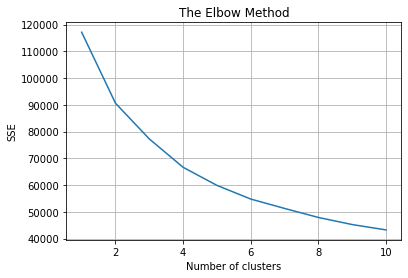

Number of Clusters:  4


In [8]:
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=100)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    
plt.plot(range(1, 11), sse)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.grid()
plt.show()
    
from kneed import KneeLocator
kl = KneeLocator( range(1, 11), sse, curve="convex", direction="decreasing")
print('Number of Clusters: ', kl.elbow)

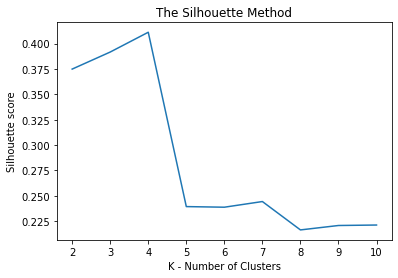

In [9]:
from sklearn.metrics import silhouette_score
silhouette_scores = [] 
    
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=100)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Lineplot using silhouette score
plt.plot(range(2, 11), silhouette_scores) 
plt.xlabel('K - Number of Clusters') 
plt.ylabel('Silhouette score') 
plt.title('The Silhouette Method') 
plt.show()

# If 4 clusters

In [10]:
kmeans4 = KMeans(n_clusters=4, n_init=100)
clusters4 = kmeans4.fit_predict(X)
all_positive_patients['cluster4'] = clusters4
all_positive_patients

,chNames,significant,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency,flipped,outcome,cluster4
2,LA3_LA4,0.0,0.066744,0.061041,-0.562039,-1.109048,-0.567220,-0.968842,1.0,1.0,3
6,LA7_LA8,0.0,0.065250,0.122859,-0.023364,-0.935368,-0.911368,-0.923101,1.0,0.0,3
7,LA8_LA9,0.0,0.102748,0.018281,0.079575,-0.848527,-1.122070,-0.305597,1.0,0.0,3
10,LAH2_LAH3,0.0,0.244097,0.378711,-0.122814,-0.978788,-1.122070,-0.945972,1.0,1.0,3
11,LAH3_LAH4,0.0,0.237456,0.179313,-0.120243,-1.022208,-1.058859,-0.968842,1.0,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...
706,RPFS6_RPFS7,0.0,-0.064879,-0.273138,0.501219,0.540917,0.170239,0.769319,0.0,0.0,3
707,RPFS7_RPFS8,0.0,0.089359,0.443343,-0.341606,-1.152468,-0.855180,-0.671525,1.0,0.0,3
708,RPFI1_RPFI2,0.0,0.064628,0.156057,-0.216732,-1.065628,0.542480,1.718446,1.0,0.0,3
709,RPFI2_RPFI3,0.0,-0.191371,-0.277875,0.924295,0.236976,-0.230096,-0.111197,0.0,0.0,3


In [11]:
df1 = all_positive_patients.iloc[:,2:11].drop(columns=['flipped','outcome'])
df1

,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency,cluster4
2,0.066744,0.061041,-0.562039,-1.109048,-0.567220,-0.968842,3
6,0.065250,0.122859,-0.023364,-0.935368,-0.911368,-0.923101,3
7,0.102748,0.018281,0.079575,-0.848527,-1.122070,-0.305597,3
10,0.244097,0.378711,-0.122814,-0.978788,-1.122070,-0.945972,3
11,0.237456,0.179313,-0.120243,-1.022208,-1.058859,-0.968842,3
...,...,...,...,...,...,...,...
706,-0.064879,-0.273138,0.501219,0.540917,0.170239,0.769319,3
707,0.089359,0.443343,-0.341606,-1.152468,-0.855180,-0.671525,3
708,0.064628,0.156057,-0.216732,-1.065628,0.542480,1.718446,3
709,-0.191371,-0.277875,0.924295,0.236976,-0.230096,-0.111197,3


Text(0.5, 1.0, 'parallel coordinates of cluster labels')

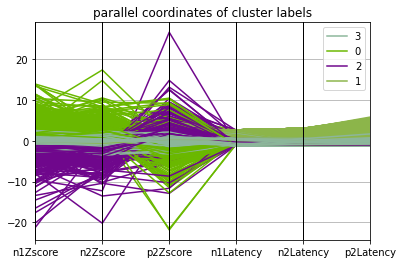

In [22]:
pd.plotting.parallel_coordinates(df1,'cluster4')
plt.title('parallel coordinates of cluster labels')

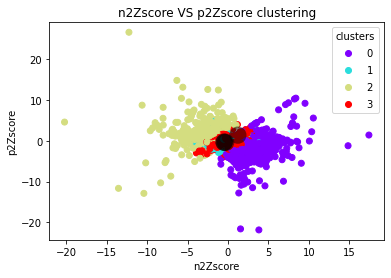

In [32]:
sc1 = plt.scatter(X.iloc[:,1], X.iloc[:,2], c=kmeans4.labels_, cmap=cm.rainbow)
plt.title('n2Zscore VS p2Zscore clustering')
plt.xlabel('n2Zscore')
plt.ylabel('p2Zscore')
#plt.legend(['cluster#1', 'cluster#2','cluster#3','cluster#4'])
plt.legend(*sc1.legend_elements(), title='clusters')
C = kmeans4.cluster_centers_
plt.scatter(C[:,3], C[:,4], c='k', marker='o', s=300, alpha=0.5, edgecolor='none')

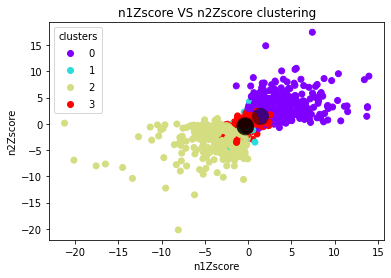

In [33]:
sc2 = plt.scatter(X.iloc[:,0], X.iloc[:,1], c=kmeans4.labels_, cmap=cm.rainbow)
plt.title('n1Zscore VS n2Zscore clustering')
plt.xlabel('n1Zscore')
plt.ylabel('n2Zscore')
plt.legend(*sc2.legend_elements(), title='clusters')
C = kmeans4.cluster_centers_
plt.scatter(C[:,4], C[:,5], c='k', marker='o', s=300, alpha=0.5, edgecolor='none')

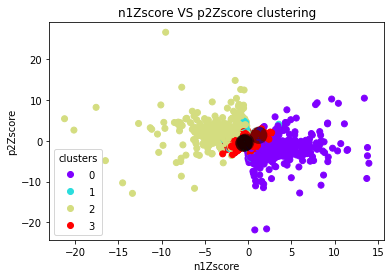

In [34]:
sc3 = plt.scatter(X.iloc[:,0], X.iloc[:,2], c=kmeans4.labels_, cmap=cm.rainbow)
plt.title('n1Zscore VS p2Zscore clustering')
plt.xlabel('n1Zscore')
plt.ylabel('p2Zscore')
plt.legend(*sc3.legend_elements(), title='clusters')
C = kmeans4.cluster_centers_
plt.scatter(C[:,3], C[:,5], c='k', marker='o', s=300, alpha=0.5, edgecolor='none')

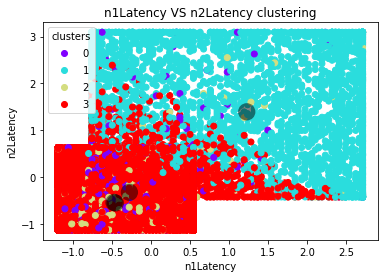

In [36]:
sc4 = plt.scatter(X.iloc[:,3], X.iloc[:,4], c=kmeans4.labels_, cmap=cm.rainbow)
plt.title('n1Latency VS n2Latency clustering')
plt.xlabel('n1Latency')
plt.ylabel('n2Latency')
plt.legend(*sc4.legend_elements(), title='clusters')
C = kmeans4.cluster_centers_
plt.scatter(C[:,3], C[:,5], c='k', marker='o', s=300, alpha=0.5, edgecolor='none')

# Compare clusters with labels

In [27]:
all_positive_patients

,chNames,significant,n1Zscore,n2Zscore,p2Zscore,n1Latency,n2Latency,p2Latency,flipped,outcome,cluster4
2,LA3_LA4,0.0,0.066744,0.061041,-0.562039,-1.109048,-0.567220,-0.968842,1.0,1.0,3
6,LA7_LA8,0.0,0.065250,0.122859,-0.023364,-0.935368,-0.911368,-0.923101,1.0,0.0,3
7,LA8_LA9,0.0,0.102748,0.018281,0.079575,-0.848527,-1.122070,-0.305597,1.0,0.0,3
10,LAH2_LAH3,0.0,0.244097,0.378711,-0.122814,-0.978788,-1.122070,-0.945972,1.0,1.0,3
11,LAH3_LAH4,0.0,0.237456,0.179313,-0.120243,-1.022208,-1.058859,-0.968842,1.0,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...
706,RPFS6_RPFS7,0.0,-0.064879,-0.273138,0.501219,0.540917,0.170239,0.769319,0.0,0.0,3
707,RPFS7_RPFS8,0.0,0.089359,0.443343,-0.341606,-1.152468,-0.855180,-0.671525,1.0,0.0,3
708,RPFI1_RPFI2,0.0,0.064628,0.156057,-0.216732,-1.065628,0.542480,1.718446,1.0,0.0,3
709,RPFI2_RPFI3,0.0,-0.191371,-0.277875,0.924295,0.236976,-0.230096,-0.111197,0.0,0.0,3


In [28]:
print('Accuracy of 4 Clusters with outcome:', np.where(all_positive_patients.outcome == all_positive_patients.cluster4)[0].size/len(all_positive_patients.outcome))

Accuracy of 4 Clusters with outcome: 0.057877484122106124


### Original Data analysis

In [29]:
print('percent of 0 in labels:', np.where(all_positive_patients.outcome == 0)[0].size/len(all_positive_patients.outcome))
print('percent of 1 in labels:', np.where(all_positive_patients.outcome == 1)[0].size/len(all_positive_patients.outcome))

percent of 0 in labels: 0.9149252202417537
percent of 1 in labels: 0.08507477975824626


### Would suggest using 4 clusters

In [30]:
# Within 4 clusters, #0 cluster

df1 = all_positive_patients[all_positive_patients.cluster4==0]
print('percent of 0 in cluster#0 of 4 clusters:', np.where(df1.outcome == 0)[0].size/len(df1.outcome))
print('percent of 1 in cluster#0 of 4 clusters:', np.where(df1.outcome == 1)[0].size/len(df1.outcome))

print('-----------------------------------------------------------------')

# Within 4 clusters, #1 cluster

df2 = all_positive_patients[all_positive_patients.cluster4==1]
print('percent of 0 in cluster#1 of 4 clusters:', np.where(df2.outcome == 0)[0].size/len(df2.outcome))
print('percent of 1 in cluster#1 of 4 clusters:', np.where(df2.outcome == 1)[0].size/len(df2.outcome))

print('-----------------------------------------------------------------')

#Within 4 clusters, #3 cluster

df3 = all_positive_patients[all_positive_patients.cluster4==2]
print('percent of 0 in cluster#2 of 4 clusters:', np.where(df3.outcome == 0)[0].size/len(df3.outcome))
print('percent of 1 in cluster#2 of 4 clusters:', np.where(df3.outcome == 1)[0].size/len(df3.outcome))

print('-----------------------------------------------------------------')

# Within 4 clusters, #4 cluster

df4 = all_positive_patients[all_positive_patients.cluster4==3]
print('percent of 0 in cluster#3 of 4 clusters:', np.where(df4.outcome == 0)[0].size/len(df4.outcome))
print('percent of 1 in cluster#3 of 4 clusters:', np.where(df4.outcome == 1)[0].size/len(df4.outcome))

percent of 0 in cluster#0 of 4 clusters: 0.95
percent of 1 in cluster#0 of 4 clusters: 0.05
-----------------------------------------------------------------
percent of 0 in cluster#1 of 4 clusters: 0.9085461177696718
percent of 1 in cluster#1 of 4 clusters: 0.0914538822303283
-----------------------------------------------------------------
percent of 0 in cluster#2 of 4 clusters: 0.9496402877697842
percent of 1 in cluster#2 of 4 clusters: 0.050359712230215826
-----------------------------------------------------------------
percent of 0 in cluster#3 of 4 clusters: 0.9129207536518241
percent of 1 in cluster#3 of 4 clusters: 0.08707924634817585


In [31]:
def roc_curve(y_true, y_cluster, threshold):
 
    y_pred = np.where(y_cluster >= threshold, 1, 0)

    fp = np.sum((y_pred == 1) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))

    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))

    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return [fpr, tpr]

fpr = roc_curve(all_positive_patients.outcome, all_positive_patients.cluster4, 1)[0]
tpr = roc_curve(all_positive_patients.outcome, all_positive_patients.cluster4, 1)[1]

print('False Positive Rate is: ', fpr)
print('True Positive Rate is: ', tpr)

False Positive Rate is:  0.9563903039802945
True Positive Rate is:  0.975316074653823
